In [10]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

In [11]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost, spin, mN = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5], mol[:,4], mol[:,3]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0) & (spin == 0) & (mN == 1)
    raw = int(cp.count_nonzero(mask).get())
    return raw

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks
seq_ori_XY = cp.tile(original_gpu[0], (10, 1))
seq_ori_XYZ1 = cp.tile(original_gpu[1], (5, 1))
seq_ori_XYZ2 = cp.tile(original_gpu[2], (5, 1))
seq_ori_XYZ3 = cp.tile(original_gpu[3], (10, 1))
seq_ori_XYZ4 = cp.tile(original_gpu[4], (10, 1))


# Repeat each block along the first axis, then concatenate in order
blocks = [
    seq_ori_XY,  
    seq_ori_XYZ1,  
    seq_ori_XYZ2,  
    seq_ori_XYZ3,  
    seq_ori_XYZ4,  
]

seq_ori = cp.concatenate(blocks, axis=0)

In [13]:
import numpy as np
import json

def convert_legacy_to_new(pulses_legacy, config):
    """
    Convert (P,3) legacy pulses to (P,4) new format using duration_matrix.
    Omega_t is interpreted as Omega_eff * t.
    New pulses: [axis, delta_n, Omega_lin_Hz, t_sec]
    """

    duration_matrix = config["duration_matrix"]

    axis_map = {0: "X", 1: "Y", 2: "Z"}

    P = pulses_legacy.shape[0]
    pulses_new = np.zeros((P, 4), dtype=float)

    for i in range(P):
        axis = int(pulses_legacy[i, 0])
        d_n = int(pulses_legacy[i, 1])
        Omega_t = float(pulses_legacy[i, 2])   # dimensionless pulse area

        axis_label = axis_map[axis]
        idx = abs(d_n)

        # pulse duration in seconds (from config, assumed accurate)
        try:
            t_sec = duration_matrix[axis_label][idx]
        except IndexError:
            raise ValueError(f"No duration entry for axis {axis_label}, |delta_n|={idx}")

        # effective angular Rabi freq (rad/s)
        Omega_eff = Omega_t / t_sec

        # convert to linear frequency (Hz)
        Omega_lin = Omega_eff / (2 * np.pi)

        pulses_new[i] = [axis, d_n, Omega_lin, t_sec]

    return pulses_new


In [5]:
with open("config.json") as f:
    cfg = json.load(f)

new_pulses = convert_legacy_to_new(seq_ori, cfg)

In [6]:
new_pulses

array([[ 0.00000000e+00, -3.00000000e+00,  1.33744856e+04,
         9.00000000e-05],
       [ 1.00000000e+00, -3.00000000e+00,  1.33744856e+04,
         9.00000000e-05],
       [ 0.00000000e+00, -2.00000000e+00,  1.71957672e+04,
         7.00000000e-05],
       ...,
       [ 0.00000000e+00, -1.00000000e+00,  5.66893424e+03,
         7.00000000e-05],
       [ 2.00000000e+00, -1.00000000e+00,  6.48148148e+03,
         2.00000000e-04],
       [ 1.00000000e+00, -1.00000000e+00,  5.66893424e+03,
         7.00000000e-05]])

Raman pulses: 100%|██████████| 280/280 [00:53<00:00,  5.21it/s]


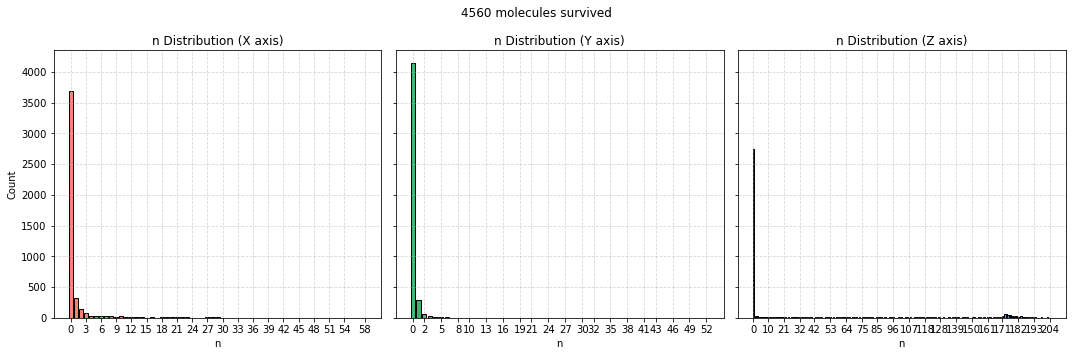

survival_rate_mean 0.456
mot_mean [ 1.20350877  0.19364035 43.67390351]
mot_sem [0.00217438 0.0005901  0.03121409]
Ground state number 2592


In [7]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, new_pulses, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])
print("Ground state number", score_sequence(mol_0))

In [8]:
np.save("original.npy", new_pulses)

In [12]:
seq_amp_oped = np.load("amp_oped.npy")

In [14]:
with open("config.json") as f:
    cfg = json.load(f)

new_pulses_oped = convert_legacy_to_new(seq_amp_oped, cfg)

In [15]:
np.unique(new_pulses_oped, axis=0)

array([[ 0.00000000e+00, -3.00000000e+00,  1.33601103e+04,
         9.00000000e-05],
       [ 0.00000000e+00, -2.00000000e+00,  2.10969036e+04,
         7.00000000e-05],
       [ 0.00000000e+00, -1.00000000e+00,  2.05170424e+04,
         7.00000000e-05],
       [ 1.00000000e+00, -3.00000000e+00,  1.44327057e+04,
         9.00000000e-05],
       [ 1.00000000e+00, -2.00000000e+00,  2.71465945e+04,
         7.00000000e-05],
       [ 1.00000000e+00, -1.00000000e+00,  1.45374101e+04,
         7.00000000e-05],
       [ 2.00000000e+00, -5.00000000e+00,  2.82254732e+04,
         7.00000000e-05],
       [ 2.00000000e+00, -4.00000000e+00,  4.19086766e+04,
         5.00000000e-05],
       [ 2.00000000e+00, -3.00000000e+00,  4.10282505e+04,
         5.00000000e-05],
       [ 2.00000000e+00, -2.00000000e+00,  8.62978335e+03,
         2.00000000e-04],
       [ 2.00000000e+00, -1.00000000e+00,  6.32292997e+03,
         2.00000000e-04]])

In [16]:
np.save("new_pulses_oped.npy", new_pulses_oped)